In [1]:
import pandas as pd
import datetime as dt
import numpy as np

In [14]:
def tbillrate():
    df = pd.read_csv("data/TB3MS.csv")
    df["observation_date"] = pd.to_datetime(df["observation_date"])
    df["TB3MS"] /= 100
    return df.set_index("observation_date")
def goldprice():
    df = pd.read_csv("cmo-data-monthly.csv")[["date","GOLD"]]
    df["date"] = pd.to_datetime(df["date"])+dt.timedelta(days=1)
    return df.set_index("date").rename(columns={"GOLD":"gold"})
def read_shiller():
    df = pd.read_csv("data/shiller.csv", header=[6])
    dflast = df.iloc[-1]
    df = df[:-1]
    df['Date'] = pd.to_datetime(["%.2f" % d for d in df['Date']], format="%Y.%m")#+dt.timedelta(days=14)
    columns={"Date":"Date","P":"SP500","D":"Div","E":"Earning","CPI":"CPI","Rate GS10":"Rate10y"}
    df.rename(columns=columns,inplace=True)
    df = df[columns.values()]
    df = df.set_index("Date")
    for c in df.columns:
        df[c] = df[c].astype(float)
    df['Rate10y'] = df['Rate10y']/100
    return df.join(tbillrate()).join(goldprice(),how="inner")

def compute_bond_tr(df):
    r = df['Rate10y']
    T = 10
    duration = -(1-np.exp(-r*T))/r
    bondcarry = r.shift(1)/12
    bondtotalret = 1+(r-r.shift(1))*duration+bondcarry
    df["bondTR"] = bondtotalret
def compute_eq_tr(df):
    df['eqTR'] = df['SP500']/df['SP500'].shift(1)+df['Div']/12/df['SP500']
def compute_gold_tr(df):
    df['gldTR'] = df['gold']/df['gold'].shift(1)
def compute_tbill_tr(df):
    df['tbTR'] = 1+df['TB3MS'].shift(1)/12
def compute_cpi_tr(df):
    df['cpiTR'] = 1+df['CPI'].pct_change()

    
df = read_shiller()
compute_bond_tr(df)
compute_eq_tr(df)
compute_gold_tr(df)
compute_tbill_tr(df)
compute_cpi_tr(df)
df.to_csv("totalreturns.csv")
df

,SP500,Div,Earning,CPI,Rate10y,TB3MS,gold,bondTR,eqTR,gldTR,tbTR,cpiTR
1960-02-01,55.780000,1.903330,3.39000,29.400,0.0449,0.0396,35.27,NaN,NaN,NaN,NaN,NaN
1960-03-01,55.020000,1.940000,3.39000,29.400,0.0425,0.0331,35.27,1.023293,0.989313,1.000000,1.003300,1.000000
1960-04-01,55.730000,1.943330,3.34667,29.500,0.0428,0.0323,35.27,1.001101,1.015810,1.000000,1.002758,1.003401
1960-05-01,55.220000,1.946670,3.30333,29.500,0.0435,0.0329,35.27,0.997890,0.993786,1.000000,1.002692,1.000000
1960-06-01,57.260000,1.950000,3.26000,29.600,0.0415,0.0246,35.27,1.019994,1.039781,1.000000,1.002742,1.003390
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-01,6029.951500,77.350000,222.53000,322.561,0.0438,0.0423,3309.49,1.006922,1.038762,1.028546,1.003542,1.003409
2025-07-01,6296.498182,77.726667,NaN,323.048,0.0439,0.0425,3352.66,1.002841,1.045232,1.013044,1.003525,1.001510
2025-08-01,6408.949524,78.103333,NaN,323.976,0.0426,0.0412,3340.15,1.014244,1.018875,0.996269,1.003542,1.002873
2025-09-01,6584.018095,78.480000,NaN,324.440,0.0412,0.0392,3368.03,1.015024,1.028310,1.008347,1.003433,1.001432


In [ ]:
from matplotlib import pyplot as plt

In [ ]:
plt.plot(df['eqTR'].cumprod(), label="SP500 total return")
plt.plot(df["bondTR"].cumprod(), label="10y TNote total return")
plt.plot(df["gldTR"].cumprod(), label="Gold total return")
plt.plot(df["tbTR"].cumprod(), label="TBill total return")
plt.plot(df["cpiTR"].cumprod(), label="cpi total return")
plt.yscale('log')
plt.grid(which="both",axis="y")
plt.grid(axis="x")
plt.legend()
plt.xlabel("last dividend data on " + str(df["Div"].dropna().index[-1])[:10])
plt.ylabel("Log Nominal Wealth")
plt.title("Total Return (Log Scale)")
plt.show()

In [ ]:
trcols = [c for c in df.columns if "TR" in c]
logret = np.log(df[trcols])
mu    = np.mean(logret,axis=0)*12
sigma = np.std(logret,axis=0)*np.sqrt(12)
corr  = logret.corr()
paramsdf = pd.DataFrame({"mu":mu,"sigma":sigma},mu.index)
r       = paramsdf.loc["tbTR","mu"]
sigma_c = paramsdf.loc["cpiTR","sigma"]
paramsdf["mu-r"] = (paramsdf["mu"]-r)
paramsdf["sharpe_nominal"] = (paramsdf["mu-r"])/paramsdf["sigma"]
paramsdf["rho_c"] = [corr.loc[c,"cpiTR"] for c in trcols]
paramsdf["sharpe_real"] = (paramsdf["mu-r"])/paramsdf["sigma"] - paramsdf["rho_c"]*sigma_c
paramsdf

In [ ]:
corr

In [ ]:
# logret 1971-02-01 2025-10-01
logret.cov()*12

In [ ]:
# Covariance Matrix:
#            bonds    equity      gold
# bonds   0.004850  0.000449 -0.000472
# equity  0.000449  0.015726 -0.000576
# gold   -0.000472 -0.000576  0.029258


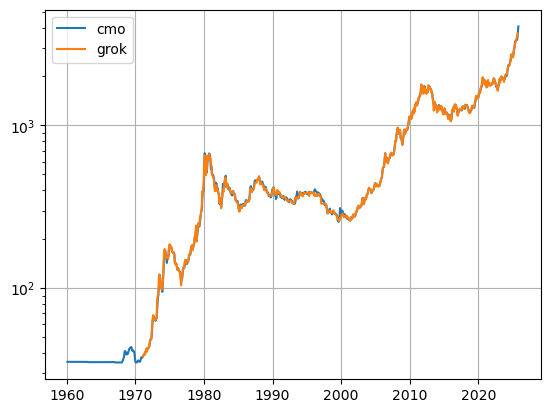

In [11]:
import matplotlib.pyplot as plt
def goldprice():
    df = pd.read_csv("cmo-data-monthly.csv")[["date","GOLD"]]
    df["date"] = pd.to_datetime(df["date"])+dt.timedelta(days=1)
    return df.set_index("date")
def goldprice2():
    df = pd.read_csv("data/gldhist.csv").rename(columns={"price":"gold"})
    df["date"] = pd.to_datetime(df["date"])+dt.timedelta(days=1)
    return df.set_index("date")
plt.plot(goldprice(),label="cmo")
plt.plot(goldprice2(),label="grok")
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()